# PU Classifier Playground (Multi-Dataset)

This notebook benchmarks the wrapped `NanoTabPFNPUClassifier` on multiple **binary** datasets from:
- `sklearn` built-ins
- OpenML
- UCI ML repository (via direct dataset URLs)

Workflow:
1. Load and preprocess each dataset into numeric features + binary labels.
2. Split into train/test.
3. Convert train split to PU by removing one class from train labels.
4. Fit wrapped classifier with `X_train_pu` only and evaluate on `X_test`.

`CHECKPOINT_PATH=None` means it loads project default `checkpoints/latest.pt` every run.

In [1]:
from pathlib import Path
import sys

repo_root = Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / "simplified_prior").exists():
    repo_root = repo_root.parent
if not (repo_root / "simplified_prior").exists():
    raise RuntimeError("Could not find repo root containing simplified_prior/.")

if str(repo_root.parent) not in sys.path:
    sys.path.insert(0, str(repo_root.parent))

print("Repo root:", repo_root)

Repo root: /Users/qltian/Library/CloudStorage/GoogleDrive-qltian2021@gmail.com/Other computers/My Laptop/Documents/Research/ai/slim_pretrain


In [2]:
from datetime import datetime
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import fetch_openml, load_breast_cancer
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from slim_pretrain.pretrain.model import NanoTabPFNPUClassifier

warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")

## Configuration

In [3]:
# Model checkpoints to compare
CHECKPOINT_PATHS = sorted((repo_root / "checkpoints").glob("latest_*.pt"))
if len(CHECKPOINT_PATHS) == 0:
    raise RuntimeError("No checkpoints found in checkpoints/ matching latest_*.pt")

DEVICE = "auto"  # auto | cpu | cuda

# PU setup
REMOVED_CLASS = 1  # which mapped class to remove from train (0 or 1)
TEST_SIZE = 0.30
RANDOM_SEED = 42
THRESHOLD = 0.50

# Feature handling
MAX_FEATURES = 20  # keep first N columns after preprocessing to align with pretraining range
USE_STANDARD_SCALER = True

# Dataset quality constraints
MIN_ROWS = 500
MIN_FEATURES = 8
MAX_ROWS_FOR_MODEL = 3000  # cap rows used per dataset to avoid O(N^2) transformer memory blowups
OPENML_CACHE_DIR = repo_root / ".cache" / "openml"
OPENML_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dataset catalog
DATASET_SPECS = [
    # sklearn
    {"source": "sklearn", "name": "breast_cancer"},

    # OpenML (binary datasets; may require internet)
    {"source": "openml", "name": "spambase", "version": 1},
    {"source": "openml", "name": "diabetes", "version": 1},
    {"source": "openml", "name": "adult", "version": 2},
    {"source": "openml", "name": "credit-g", "version": 1},

    # UCI ML repository via direct links (binary datasets)
    {
        "source": "uci_url",
        "name": "adult_uci_train",
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "sep": ",",
        "header": None,
        "target_col": 14,
        "drop_cols": [],
    },
    {
        "source": "uci_url",
        "name": "mushroom",
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
        "sep": ",",
        "header": None,
        "target_col": 0,
        "drop_cols": [],
    },
    {
        "source": "uci_url",
        "name": "magic04",
        "url": "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data",
        "sep": ",",
        "header": None,
        "target_col": 10,
        "drop_cols": [],
    },
]


In [4]:
def resolve_device(device_arg: str) -> str:
    if device_arg == "auto":
        return "cuda" if torch.cuda.is_available() else "cpu"
    if device_arg == "cuda" and not torch.cuda.is_available():
        raise RuntimeError("CUDA requested but not available.")
    return device_arg


def _coerce_binary_target(y_raw: pd.Series) -> Tuple[np.ndarray, Dict[str, int]]:
    y_series = pd.Series(y_raw).copy()
    y_series = y_series.replace(["?", "nan", "None"], np.nan)
    valid = y_series.notna()
    y_series = y_series[valid]

    labels = list(pd.unique(y_series))
    if len(labels) != 2:
        raise ValueError(f"Expected binary labels, got {len(labels)} labels: {labels[:10]}")

    mapping = {labels[0]: 0, labels[1]: 1}
    y = y_series.map(mapping).astype(np.int64).to_numpy()
    mapping_printable = {str(k): int(v) for k, v in mapping.items()}
    return y, mapping_printable


def _coerce_numeric_features(X_raw: pd.DataFrame) -> np.ndarray:
    X_df = pd.DataFrame(X_raw).copy()
    for c in X_df.columns:
        if not pd.api.types.is_numeric_dtype(X_df[c]):
            X_df[c] = X_df[c].astype(str)

    X_df = pd.get_dummies(X_df, dummy_na=True, drop_first=False)
    X_df = X_df.replace([np.inf, -np.inf], np.nan)

    numeric_medians = X_df.median(numeric_only=True)
    X_df = X_df.fillna(numeric_medians)
    X_df = X_df.fillna(0.0)
    return X_df.to_numpy(dtype=np.float32)


def load_dataset_from_spec(spec: Dict[str, object], random_seed: int) -> Dict[str, object]:
    source = str(spec["source"])
    name = str(spec["name"])

    if source == "sklearn" and name == "breast_cancer":
        ds = load_breast_cancer(as_frame=True)
        X_raw = ds.data
        y_raw = ds.target

    elif source == "openml":
        version = spec.get("version", 1)
        ds = fetch_openml(name=name, version=version, as_frame=True, data_home=str(OPENML_CACHE_DIR))
        X_raw = ds.data
        y_raw = ds.target

    elif source == "uci_url":
        url = str(spec["url"])
        sep = spec.get("sep", ",")
        header = spec.get("header", None)
        target_col = int(spec["target_col"])
        drop_cols = spec.get("drop_cols", [])

        raw = pd.read_csv(url, sep=sep, header=header, skipinitialspace=True)
        y_raw = raw.iloc[:, target_col]

        feature_cols = [c for c in raw.columns if c != target_col and c not in drop_cols]
        X_raw = raw.loc[:, feature_cols]

    else:
        raise ValueError(f"Unsupported dataset spec: {spec}")

    X = _coerce_numeric_features(X_raw)
    y, label_mapping = _coerce_binary_target(pd.Series(y_raw))

    # Align rows in case y had invalid/missing labels filtered away
    if X.shape[0] != len(y):
        y_series = pd.Series(y_raw).replace(["?", "nan", "None"], np.nan)
        valid = y_series.notna().to_numpy()
        X = X[valid]

    if MAX_FEATURES is not None and MAX_FEATURES > 0 and X.shape[1] > MAX_FEATURES:
        X = X[:, :MAX_FEATURES]

    return {
        "source": source,
        "name": name,
        "X": X.astype(np.float32),
        "y": y.astype(np.int64),
        "label_mapping": label_mapping,
        "n_rows": int(X.shape[0]),
        "n_features": int(X.shape[1]),
    }


def build_pu_train_data(
    X_train: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    removed_class: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if removed_class not in {0, 1}:
        raise ValueError("REMOVED_CLASS must be 0 or 1.")

    y_train_adj = y_train.copy()
    y_test_adj = y_test.copy()

    # Match prior generator convention: observed train class is class 0.
    if removed_class == 0:
        y_train_adj = 1 - y_train_adj
        y_test_adj = 1 - y_test_adj

    keep_mask = y_train_adj == 0
    X_train_pu = X_train[keep_mask]
    if X_train_pu.shape[0] == 0:
        raise RuntimeError("No rows left in PU train split.")

    return X_train_pu, y_train_adj, y_test_adj


def evaluate_single_dataset(
    clf: NanoTabPFNPUClassifier,
    X: np.ndarray,
    y: np.ndarray,
    seed: int,
    test_size: float,
    removed_class: int,
    threshold: float,
    use_standard_scaler: bool,
    max_rows_for_model: Optional[int],
) -> Dict[str, object]:
    X_eval = X
    y_eval = y
    if max_rows_for_model is not None and X.shape[0] > max_rows_for_model:
        X_eval, _, y_eval, _ = train_test_split(
            X,
            y,
            train_size=max_rows_for_model,
            random_state=seed,
            stratify=y,
        )

    X_train, X_test, y_train, y_test = train_test_split(
        X_eval, y_eval, test_size=test_size, random_state=seed, stratify=y_eval
    )

    X_train_pu, y_train_adj, y_test_adj = build_pu_train_data(
        X_train=X_train,
        y_train=y_train,
        y_test=y_test,
        removed_class=removed_class,
    )

    if use_standard_scaler:
        scaler = StandardScaler()
        scaler.fit(np.concatenate([X_train_pu, X_test], axis=0))
        X_train_pu = scaler.transform(X_train_pu).astype(np.float32)
        X_test = scaler.transform(X_test).astype(np.float32)

    clf.fit(X_train_pu)
    proba = clf.predict_proba(X_test)[:, 1]
    pred = (proba >= threshold).astype(np.int64)

    metrics = {
        "accuracy": float(accuracy_score(y_test_adj, pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_test_adj, pred)),
        "f1": float(f1_score(y_test_adj, pred)),
        "average_precision": float(average_precision_score(y_test_adj, proba)),
        "roc_auc": float(roc_auc_score(y_test_adj, proba)),
        "rows_used_for_eval": int(X_eval.shape[0]),
        "labeled_positive_train_n": int(X_train_pu.shape[0]),
        "unlabeled_test_n": int(X_test.shape[0]),
        "test_inliers_n": int((y_test_adj == 0).sum()),
        "test_outliers_n": int((y_test_adj == 1).sum()),
        "train_rows_full": int(X_train.shape[0]),
        "train_rows_pu": int(X_train_pu.shape[0]),
        "test_rows": int(X_test.shape[0]),
        "train_class0": int((y_train_adj == 0).sum()),
        "train_class1": int((y_train_adj == 1).sum()),
        "test_class0": int((y_test_adj == 0).sum()),
        "test_class1": int((y_test_adj == 1).sum()),
        "cm_00": int(confusion_matrix(y_test_adj, pred, labels=[0, 1])[0, 0]),
        "cm_01": int(confusion_matrix(y_test_adj, pred, labels=[0, 1])[0, 1]),
        "cm_10": int(confusion_matrix(y_test_adj, pred, labels=[0, 1])[1, 0]),
        "cm_11": int(confusion_matrix(y_test_adj, pred, labels=[0, 1])[1, 1]),
    }
    return metrics

In [5]:
device = resolve_device(DEVICE)
checkpoint_paths = [Path(cp).expanduser().resolve() for cp in CHECKPOINT_PATHS]

if len(checkpoint_paths) == 0:
    raise RuntimeError("No checkpoint paths available for comparison.")

checkpoint_infos = []
for cp in checkpoint_paths:
    checkpoint_infos.append({
        "checkpoint_name": cp.stem,
        "path": str(cp),
        "modified_time": datetime.fromtimestamp(cp.stat().st_mtime).isoformat(sep=" ", timespec="seconds"),
    })

print(f"Found {len(checkpoint_paths)} checkpoints for comparison.")
print("Device:", device)
display(pd.DataFrame(checkpoint_infos))

# quick-start section below uses the first checkpoint as an example
example_checkpoint = checkpoint_paths[0]


Found 4 checkpoints for comparison.
Device: cpu


,checkpoint_name,path,modified_time
0,latest_A,/Users/qltian/Library/CloudStorage/GoogleDrive...,2026-02-15 02:01:07
1,latest_B,/Users/qltian/Library/CloudStorage/GoogleDrive...,2026-02-15 02:00:29
2,latest_C,/Users/qltian/Library/CloudStorage/GoogleDrive...,2026-02-15 01:46:34
3,latest_S,/Users/qltian/Library/CloudStorage/GoogleDrive...,2026-02-15 02:01:42


## Quick Start: Use The Wrapped Classifier (Breast Cancer Example)

This is the minimal workflow for one dataset:
1. Load binary data (`X`, `y`).
2. Split into train/test.
3. Convert train to PU train by removing one class (`build_pu_train_data`).
4. Fit classifier with `X_train_pu` only.
5. Run inference on `X_test` and compute metrics.

In [6]:
# Example usage with sklearn breast cancer data
bc = load_breast_cancer()
X_bc = bc.data.astype(np.float32)
y_bc = bc.target.astype(np.int64)

if MAX_FEATURES is not None and MAX_FEATURES > 0 and X_bc.shape[1] > MAX_FEATURES:
    X_bc = X_bc[:, :MAX_FEATURES]

X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_bc,
    y_bc,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y_bc,
)

X_train_pu_bc, y_train_adj_bc, y_test_adj_bc = build_pu_train_data(
    X_train=X_train_bc,
    y_train=y_train_bc,
    y_test=y_test_bc,
    removed_class=REMOVED_CLASS,
)

if USE_STANDARD_SCALER:
    scaler_bc = StandardScaler()
    scaler_bc.fit(np.concatenate([X_train_pu_bc, X_test_bc], axis=0))
    X_train_pu_bc = scaler_bc.transform(X_train_pu_bc).astype(np.float32)
    X_test_bc = scaler_bc.transform(X_test_bc).astype(np.float32)

# fit takes X_train_pu only (no y_train argument)
clf_bc = NanoTabPFNPUClassifier.from_checkpoint(example_checkpoint, device=device)
clf_bc.fit(X_train_pu_bc)

proba_bc = clf_bc.predict_proba(X_test_bc)[:, 1]
pred_bc = (proba_bc >= THRESHOLD).astype(np.int64)

metrics_bc = {
    "checkpoint_name": example_checkpoint.stem,
    "accuracy": float(accuracy_score(y_test_adj_bc, pred_bc)),
    "balanced_accuracy": float(balanced_accuracy_score(y_test_adj_bc, pred_bc)),
    "f1": float(f1_score(y_test_adj_bc, pred_bc)),
    "average_precision": float(average_precision_score(y_test_adj_bc, proba_bc)),
    "roc_auc": float(roc_auc_score(y_test_adj_bc, proba_bc)),
}

counts_bc = {
    "checkpoint_name": example_checkpoint.stem,
    "labeled_positive_train_n": int(X_train_pu_bc.shape[0]),
    "unlabeled_test_n": int(X_test_bc.shape[0]),
    "test_inliers_n": int((y_test_adj_bc == 0).sum()),
    "test_outliers_n": int((y_test_adj_bc == 1).sum()),
}

print("Example checkpoint:", example_checkpoint)
print("Label semantics: class 0 = inlier (positive), class 1 = outlier.")
display(pd.DataFrame([counts_bc]))
display(pd.DataFrame([metrics_bc]))


Example checkpoint: /Users/qltian/Library/CloudStorage/GoogleDrive-qltian2021@gmail.com/Other computers/My Laptop/Documents/Research/ai/slim_pretrain/checkpoints/latest_A.pt
Label semantics: class 0 = inlier (positive), class 1 = outlier.


,checkpoint_name,labeled_positive_train_n,unlabeled_test_n,test_inliers_n,test_outliers_n
0,latest_A,148,171,64,107


,checkpoint_name,accuracy,balanced_accuracy,f1,average_precision,roc_auc
0,latest_A,0.900585,0.914282,0.915423,0.991609,0.987296


In [7]:
loaded = []
failed = []

for spec in DATASET_SPECS:
    try:
        ds = load_dataset_from_spec(spec, random_seed=RANDOM_SEED)
        if ds['n_rows'] < MIN_ROWS or ds['n_features'] < MIN_FEATURES:
            reason = f"rows={ds['n_rows']} (<{MIN_ROWS}) or cols={ds['n_features']} (<{MIN_FEATURES})"
            failed.append({"spec": spec, "error": reason})
            print(f"[SKIP] {ds['source']}::{ds['name']} -> {reason}")
            continue
        loaded.append(ds)
        print(f"[OK] {ds['source']}::{ds['name']} rows={ds['n_rows']} cols={ds['n_features']} labels={ds['label_mapping']}")
    except Exception as exc:
        failed.append({"spec": spec, "error": str(exc)})
        print(f"[SKIP] {spec['source']}::{spec['name']} -> {exc}")

print()
print(f"Loaded {len(loaded)} datasets, skipped {len(failed)} datasets.")

[OK] sklearn::breast_cancer rows=569 cols=20 labels={'0': 0, '1': 1}
[OK] openml::spambase rows=4601 cols=20 labels={'1': 0, '0': 1}
[OK] openml::diabetes rows=768 cols=8 labels={'tested_positive': 0, 'tested_negative': 1}
[OK] openml::adult rows=48842 cols=20 labels={'<=50K': 0, '>50K': 1}
[OK] openml::credit-g rows=1000 cols=20 labels={'good': 0, 'bad': 1}
[OK] uci_url::adult_uci_train rows=32561 cols=20 labels={'<=50K': 0, '>50K': 1}
[OK] uci_url::mushroom rows=8124 cols=20 labels={'p': 0, 'e': 1}
[OK] uci_url::magic04 rows=19020 cols=10 labels={'g': 0, 'h': 1}

Loaded 8 datasets, skipped 0 datasets.


In [8]:
rows = []

for cp in checkpoint_paths:
    ckpt_name = cp.stem
    try:
        clf = NanoTabPFNPUClassifier.from_checkpoint(cp, device=device)
    except Exception as exc:
        failed.append({"spec": {"source": "checkpoint", "name": ckpt_name}, "error": str(exc)})
        print(f"[MODEL SKIP] {ckpt_name} -> {exc}")
        continue

    print(f"Evaluating checkpoint: {ckpt_name}")
    for ds in loaded:
        try:
            m = evaluate_single_dataset(
                clf=clf,
                X=ds['X'],
                y=ds['y'],
                seed=RANDOM_SEED,
                test_size=TEST_SIZE,
                removed_class=REMOVED_CLASS,
                threshold=THRESHOLD,
                use_standard_scaler=USE_STANDARD_SCALER,
                max_rows_for_model=MAX_ROWS_FOR_MODEL,
            )
            m.update({
                'checkpoint_name': ckpt_name,
                'checkpoint_path': str(cp),
                'source': ds['source'],
                'dataset': ds['name'],
                'n_rows': ds['n_rows'],
                'n_features': ds['n_features'],
                'label_mapping': str(ds['label_mapping']),
            })
            rows.append(m)
        except Exception as exc:
            failed.append({"spec": {"source": ds['source'], "name": f"{ds['name']}@{ckpt_name}"}, "error": str(exc)})
            print(f"[EVAL SKIP] {ckpt_name}::{ds['source']}::{ds['name']} -> {exc}")

results_df = pd.DataFrame(rows)
if len(results_df) == 0:
    raise RuntimeError("No successful dataset evaluations.")

count_cols = ['labeled_positive_train_n', 'unlabeled_test_n', 'test_inliers_n', 'test_outliers_n']
metric_cols = ['accuracy', 'balanced_accuracy', 'f1', 'average_precision', 'roc_auc']

print('Count semantics: class 0 = inlier (positive), class 1 = outlier.')
display(
    results_df[
        ['checkpoint_name', 'source', 'dataset', 'n_rows', 'rows_used_for_eval', 'n_features']
        + count_cols
        + metric_cols
    ]
    .sort_values(['checkpoint_name', 'dataset'])
    .reset_index(drop=True)
)

roc_auc_pivot = results_df.pivot_table(index='dataset', columns='checkpoint_name', values='roc_auc')
print('ROC-AUC comparison by dataset (higher is better):')
display(roc_auc_pivot)


Evaluating checkpoint: latest_A
Evaluating checkpoint: latest_B
Evaluating checkpoint: latest_C
Evaluating checkpoint: latest_S
Count semantics: class 0 = inlier (positive), class 1 = outlier.


,checkpoint_name,source,dataset,n_rows,rows_used_for_eval,n_features,labeled_positive_train_n,unlabeled_test_n,test_inliers_n,test_outliers_n,accuracy,balanced_accuracy,f1,average_precision,roc_auc
0,latest_A,openml,adult,48842,3000,20,1597,900,685,215,0.556667,0.638550,0.461538,0.563803,0.744824
1,latest_A,uci_url,adult_uci_train,32561,3000,20,1595,900,683,217,0.588889,0.652104,0.475921,0.579975,0.754283
2,latest_A,sklearn,breast_cancer,569,569,20,148,171,64,107,0.900585,0.914282,0.915423,0.991609,0.987296
3,latest_A,openml,credit-g,1000,1000,20,490,300,210,90,0.636667,0.661111,0.543933,0.528671,0.735820
4,latest_A,openml,diabetes,768,768,8,187,231,81,150,0.735931,0.754074,0.773234,0.893342,0.818272
5,latest_A,uci_url,magic04,19020,3000,10,1361,900,584,316,0.830000,0.835606,0.779221,0.896998,0.915435
6,latest_A,uci_url,mushroom,8124,3000,20,1012,900,434,466,0.517778,0.500000,0.682284,0.491066,0.464179
7,latest_A,openml,spambase,4601,3000,20,827,900,355,545,0.785556,0.802313,0.803262,0.904075,0.888727
8,latest_B,openml,adult,48842,3000,20,1597,900,685,215,0.765556,0.689611,0.525843,0.575472,0.760475
9,latest_B,uci_url,adult_uci_train,32561,3000,20,1595,900,683,217,0.756667,0.677753,0.510067,0.553824,0.732071


ROC-AUC comparison by dataset (higher is better):


checkpoint_name,latest_A,latest_B,latest_C,latest_S
dataset,,,,
adult,0.744824,0.760475,0.771319,0.739481
adult_uci_train,0.754283,0.732071,0.784281,0.782351
breast_cancer,0.987296,0.987880,0.986273,0.987588
credit-g,0.735820,0.726138,0.741587,0.750741
diabetes,0.818272,0.800741,0.799671,0.805432
magic04,0.915435,0.924636,0.928277,0.919943
mushroom,0.464179,0.470850,0.533101,0.558565
spambase,0.888727,0.870560,0.899173,0.886541


Overall summary across all checkpoints and datasets:


,mean,std,min,max
accuracy,0.722260,0.125448,0.517778,0.923977
balanced_accuracy,0.729149,0.125699,0.500000,0.932973
f1,0.691270,0.154573,0.461538,0.936585
average_precision,0.737854,0.188627,0.491066,0.991860
roc_auc,0.795516,0.140537,0.464179,0.987880


Mean metrics by checkpoint:


,accuracy,balanced_accuracy,f1,average_precision,roc_auc
checkpoint_name,,,,,
latest_C,0.724344,0.736957,0.698804,0.748357,0.805460
latest_S,0.724864,0.733529,0.696377,0.745922,0.803830
latest_A,0.694009,0.719755,0.679352,0.731192,0.788604
latest_B,0.745821,0.726357,0.690546,0.725945,0.784169


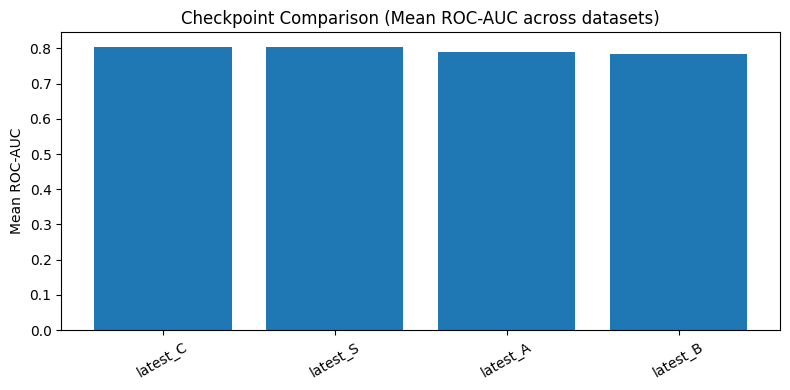

In [9]:
metric_cols = ['accuracy', 'balanced_accuracy', 'f1', 'average_precision', 'roc_auc']

overall_agg = results_df[metric_cols].agg(['mean', 'std', 'min', 'max']).T
print('Overall summary across all checkpoints and datasets:')
display(overall_agg)

agg_by_checkpoint = results_df.groupby('checkpoint_name')[metric_cols].mean().sort_values('roc_auc', ascending=False)
print('Mean metrics by checkpoint:')
display(agg_by_checkpoint)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(agg_by_checkpoint.index.astype(str), agg_by_checkpoint['roc_auc'])
ax.set_ylabel('Mean ROC-AUC')
ax.set_title('Checkpoint Comparison (Mean ROC-AUC across datasets)')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


In [10]:
if failed:
    failed_df = pd.DataFrame([
        {"source": f['spec'].get('source', 'unknown'), "dataset": f['spec'].get('name', 'unknown'), "error": f['error']}
        for f in failed
    ])
    display(failed_df)
else:
    print('No skipped/failed datasets.')

No skipped/failed datasets.


## Notes

- OpenML/UCI loading requires internet access at notebook runtime.
- Only datasets with `n_rows >= MIN_ROWS` and `n_features >= MIN_FEATURES` are evaluated.
- For stability, each dataset is optionally subsampled to `MAX_ROWS_FOR_MODEL` before inference (transformer cost grows roughly with rows^2).
- This notebook compares all checkpoints matching `checkpoints/latest_*.pt`.
- If you replace any checkpoint file, rerun from the checkpoint discovery cell to refresh comparison results.
- For larger dataset lists, add more entries to `DATASET_SPECS`.
